In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
def get_data(path: str) -> tuple[pd.DataFrame, np.ndarray]:
    current_base = 0
    offset = 0
    section = "start"
    band_start = 0
    band_end = 0

    final_path = []
    data = []

    with open(path, "r") as f:
        next(f)
        for l in f:
            l = l.strip()
            if l.startswith("# base"):
                l = l.split(" ")
                current_base = int(l[1].split("=")[1])
                offset = int(l[2].split("=")[1])

                band_start = int(l[4].split("=")[1])
                band_end = int(l[5].split("=")[1])
            elif l.startswith("# start"):
                section = "start"
            elif l.startswith("# overlap"):
                section = "overlap"
            elif l.startswith("# rest"):
                section = "rest"
            elif l.startswith("# path"):
                final_path = np.array([int(e) for e in l.split("=")[1].split(",")])
            # Hack for multiple iterations (fishnet stores the data from all iterations
            # but I'm only interested in the last one)
            elif l.startswith("band_pos"):
                current_base = 0
                offset = 0
                section = "start"
                band_start = 0
                band_end = 0

                final_path = []
                data = []
            else:
                l = l.split("\t")

                band_pos = int(l[0])
                base_score = float(l[1])
                move_score = None if l[2] == "NA" else float(l[2])
                stay_score = None if l[3] == "NA" else float(l[3])
                action = l[4]
                tb_value = int(l[5])

                data.append([
                    current_base, 
                    offset, 
                    band_pos, 
                    base_score, 
                    move_score, 
                    stay_score, 
                    action, 
                    tb_value,
                    section,
                    band_start,
                    band_end
                ])

    return pd.DataFrame(data, columns=[
        "current_base", "offset", "band_pos", "base_score", "move_score", 
        "stay_score", "action", "tb_value", "section", "band_start", "band_end"
    ]), final_path

def get_score_matrix(data: pd.DataFrame) -> np.ndarray:
    last_row = data.iloc[-1]
    matrix = np.full((last_row["band_end"], last_row["current_base"]+1), np.nan)
    for row in data.iterrows():
        row = row[1]
        base_idx = row["current_base"]
        signal_idx = row["band_start"] + row["band_pos"]
        score = row["move_score"] if row["action"]=="move" else row["stay_score"]

        matrix[signal_idx, base_idx] = score

    return matrix

In [22]:
def get_data_dwell_penalty(path: str) -> tuple[pd.DataFrame, np.ndarray]:
    with open(path, "r") as f:
        for l in f:
            l = l.strip()
            # beginning of data
            if l.startswith("band_pos"):
                data = []
                base = 0
                band_start = 0
                band_end = 0
                skip_viterbi = False
                continue

            # if '# viterbi' comes, skip until after '# viterbi_finished' comes
            if l.startswith("# viterbi"):
                skip_viterbi = True

            if skip_viterbi:
                if l.startswith("# viterbi_finished"):
                    skip_viterbi = False
                continue

            if l.startswith("# base"):
                l_spl = l.split(" ")
                current_base = int(l_spl[1].split("=")[1])
                
                offset_from = int(l_spl[2].split("=")[1])
                offset_to = int(l_spl[3].split("=")[1])

                band_start = int(l_spl[4].split("=")[1])
                band_end = int(l_spl[5].split("=")[1])
                continue
            
            if l.startswith("# path"):
                path = np.array([int(i) for i in l.split("=")[1].split(",")])
                continue

            l = l.split("\t")
            data.append([
                int(l[0]),
                float(l[1]),
                int(l[2]),
                float(l[3]),
                int(l[4]),
                current_base,
                offset_from,
                offset_to,
                band_start,
                band_end
            ])

        data = pd.DataFrame(data, columns=[
            "band_pos", "unpen_score", "unpen_tb", "pen_score", "pen_tb",
            "current_base", "chunk_start", "chunk_end", "band_start", "band_end"
        ])
        return data, path
    
def get_score_matrix_dwell_penalty(data: pd.DataFrame) -> np.ndarray:
    last_row = data.iloc[-1]
    matrix = np.full((2, last_row["band_end"].astype(int), last_row["current_base"].astype(int)+1), np.nan)
    for row in data.iterrows():
        row = row[1]
        base_idx = row["current_base"].astype(int)
        signal_idx = row["band_start"].astype(int) + row["band_pos"].astype(int)

        matrix[0, signal_idx, base_idx] = row["unpen_score"]
        matrix[1, signal_idx, base_idx] = row["pen_score"]

    return matrix

In [29]:
from matplotlib.figure import Figure
def plot_scores(matrix: np.ndarray, path: list[int], title: str) -> Figure:
    fig, ax = plt.subplots(figsize=(10,5))

    im = ax.pcolor(matrix)
    fig.colorbar(im, ax=ax, label="Score")

    ax.plot(path, color="red")
    ax.set_xlabel("Base index")
    ax.set_ylabel("Signal index")
    ax.set_title(title)

    return fig

In [ ]:
BASEDIR=".../remora/extracting_scores"

In [23]:
def load_data(basename: str) -> tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    path_log = os.path.join(BASEDIR, f"{basename}_log.txt")
    path_alignment = os.path.join(BASEDIR, f"{basename}_alignment.txt")

    if "dwell_penalty" in basename:
        data, path = get_data_dwell_penalty(path_log)
        score_matrix = get_score_matrix_dwell_penalty(data)
    else:
        data, path = get_data(path_log)
        score_matrix = get_score_matrix(data)

    alignment = np.loadtxt(path_alignment)

    return data, path, score_matrix, alignment

In [25]:
data1, path1, score_matrix1, alignment1 = load_data("viterbi_false")
data2, path2, score_matrix2, alignment2 = load_data("dwell_penalty_false")
data3, path3, score_matrix3, alignment3 = load_data("dwell_penalty_true")

Text(0.5, 1.0, 'Banded DP scores and constructed path (Viterbi, no rough rescaling)')

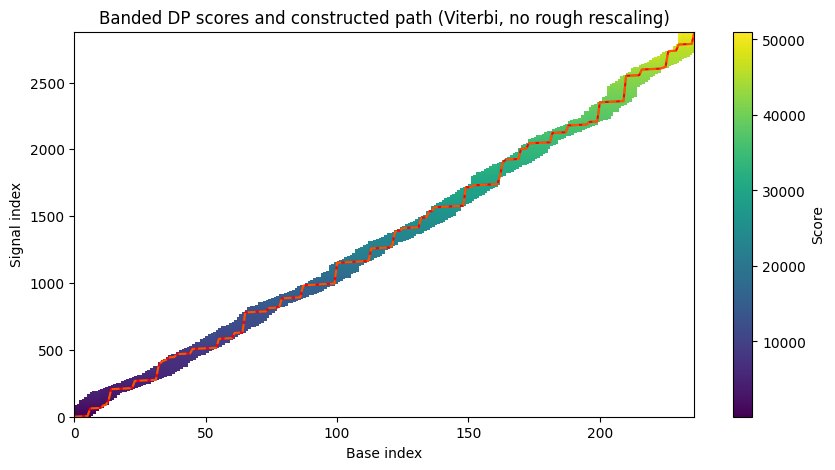

In [43]:
fig, ax = plt.subplots(figsize=(10,5))

im = ax.pcolor(score_matrix1)
fig.colorbar(im, ax=ax, label="Score")

ax.plot(path1, color="red")
ax.plot(alignment1, color="orange", alpha=0.5, linestyle="--")
ax.set_xlabel("Base index")
ax.set_ylabel("Signal index")
ax.set_title("Banded DP scores and constructed path (Viterbi, no rough rescaling)")

Text(0.5, 1.0, 'Banded DP scores and constructed path (Dwell pen., no rough rescaling)')

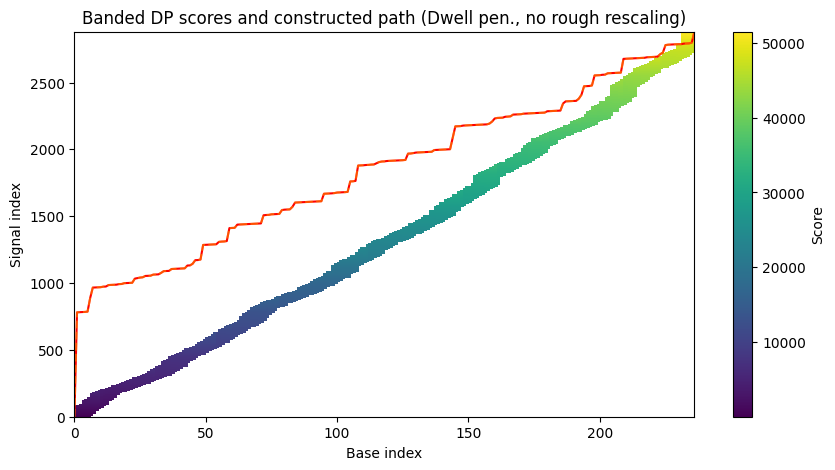

In [45]:
fig, ax = plt.subplots(figsize=(10,5))

im = ax.pcolor(score_matrix2[1])
fig.colorbar(im, ax=ax, label="Score")

ax.plot(path2, color="red")
ax.plot(alignment2, color="orange", alpha=0.5, linestyle="--")
ax.set_xlabel("Base index")
ax.set_ylabel("Signal index")
ax.set_title("Banded DP scores and constructed path (Dwell pen., no rough rescaling)")


Text(0.5, 1.0, 'Banded DP scores and constructed path (Dwell pen., with rough rescaling)')

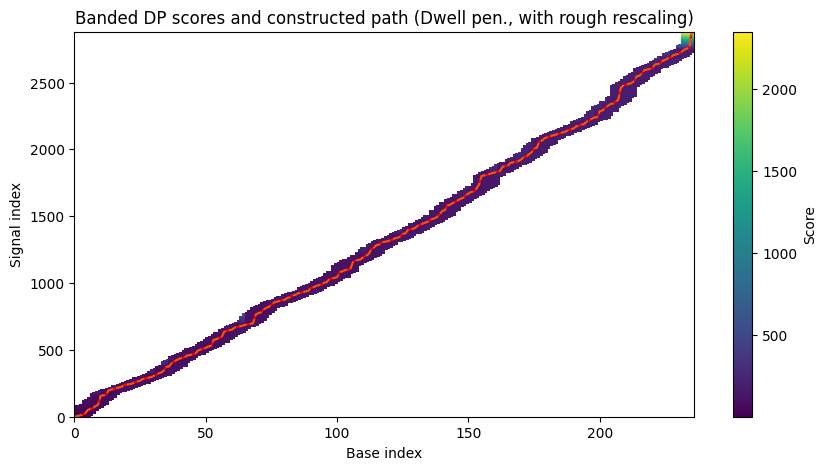

In [44]:
fig, ax = plt.subplots(figsize=(10,5))

im = ax.pcolor(score_matrix3[1])
fig.colorbar(im, ax=ax, label="Score")

ax.plot(path3, color="red")
ax.plot(alignment3, color="orange", alpha=0.5, linestyle="--")
ax.set_xlabel("Base index")
ax.set_ylabel("Signal index")
ax.set_title("Banded DP scores and constructed path (Dwell pen., with rough rescaling)")
